
[Deep Residual Learning for Image Recognition.pdf](./Deep%20Residual%20Learning%20for%20Image%20Recognition.pdf)

In [45]:
import os
import torch
import torchvision as tv
from torch import nn
from PIL import Image
from torchvision import transforms
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

In [46]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
batch_size = 192
num_epoch = 10
num_class = 10 # cifar10
lr = 1e-3
loss_func = nn.CrossEntropyLoss()
# torch.autograd.set_detect_anomaly(True)

In [47]:
import torchvision as tv
from torchvision import transforms


transform = transforms.Compose([
    # transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = tv.datasets.cifar.CIFAR10("./cifar10_dataset",train=True,  download=True, transform=transform)
test_data = tv.datasets.cifar.CIFAR10("./cifar10_dataset",train=False,  download=True, transform=transform)

train_iter = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

for x, y in train_data:
    print(x.shape, y)
    break

torch.Size([3, 32, 32]) 6


In [ ]:
from torch import Tensor


class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        """
        stride: 第一层是否下采样
        """
        super(ResBlock, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride),
            nn.BatchNorm2d(out_channels),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x: Tensor):
        result = self.layer2(self.layer1(x))
        result += self.shortcut(x)
        return F.relu(result)

In [49]:
class ResNet(nn.Module):
    def __init__(self, num_class=10):
        super(ResNet, self).__init__()
        self.num_classes = num_class
        self.layer0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = nn.Sequential(
            ResBlock(in_channels=64, out_channels=64, stride=1),
            ResBlock(in_channels=64, out_channels=64, stride=1),
        )
        self.layer2 = nn.Sequential(
            ResBlock(in_channels=64, out_channels=128, stride=2),
            ResBlock(in_channels=128, out_channels=128, stride=1),
        )
        self.layer3 = nn.Sequential(
            ResBlock(in_channels=128, out_channels=256, stride=2),
            ResBlock(in_channels=256, out_channels=256, stride=1),
        )
        self.layer4 = nn.Sequential(
            ResBlock(in_channels=256, out_channels=512, stride=2),
            ResBlock(in_channels=512, out_channels=512, stride=1),
        )
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, self.num_classes)

    def forward(self, x: Tensor):
        out = self.layer0(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [50]:
from torchsummary import summary

summary(ResNet(10))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
|    └─ResBlock: 2-4                     --
|    |    └─Sequential: 3-1              37,056
|    |    └─Sequential: 3-2              37,056
|    |    └─Sequential: 3-3              --
|    └─ResBlock: 2-5                     --
|    |    └─Sequential: 3-4              37,056
|    |    └─Sequential: 3-5              37,056
|    |    └─Sequential: 3-6              --
├─Sequential: 1-3                        --
|    └─ResBlock: 2-6                     --
|    |    └─Sequential: 3-7              74,112
|    |    └─Sequential: 3-8              147,840
|    |    └─Sequential: 3-9              8,576
|    └─ResBlock: 2-7                     --
|    |    └─Sequential: 3-10             147,840
|    |    └─Sequential: 3-11      

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
|    └─ResBlock: 2-4                     --
|    |    └─Sequential: 3-1              37,056
|    |    └─Sequential: 3-2              37,056
|    |    └─Sequential: 3-3              --
|    └─ResBlock: 2-5                     --
|    |    └─Sequential: 3-4              37,056
|    |    └─Sequential: 3-5              37,056
|    |    └─Sequential: 3-6              --
├─Sequential: 1-3                        --
|    └─ResBlock: 2-6                     --
|    |    └─Sequential: 3-7              74,112
|    |    └─Sequential: 3-8              147,840
|    |    └─Sequential: 3-9              8,576
|    └─ResBlock: 2-7                     --
|    |    └─Sequential: 3-10             147,840
|    |    └─Sequential: 3-11      

In [51]:
net = ResNet(num_class).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

train_loss, test_loss, train_acc, test_acc = [], [], [], []

for epoch in range(num_epoch):
    net.train()
    train_loss_epoch, train_acc_epoch, img_cnt = 0, 0, 0
    for x, y in train_iter:
        x, y = x.to(device), y.to(device)
        pred: Tensor = net(x)
        los = loss_func(pred, y)
        los.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_epoch += los.item()
        img_cnt += y.shape[0]
        train_acc_epoch += (pred.argmax(dim=1) == y).sum().item()
    train_loss_epoch /= img_cnt
    train_acc_epoch /= img_cnt
    train_loss.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)
    # ------
    net.eval()
    test_loss_epoch, img_cnt, test_acc_epoch = 0, 0, 0
    with torch.no_grad():
        for x, y in test_iter:
            x, y = x.to(device), y.to(device)
            pred: Tensor = net(x)
            los = loss_func(pred, y)
            test_loss_epoch += los.item()
            test_acc_epoch += (pred.argmax(dim=1) == y).sum().item()
            img_cnt += y.shape[0]

    test_loss_epoch /= img_cnt
    test_acc_epoch /= img_cnt

    test_loss.append(test_loss_epoch)
    test_acc.append(test_acc_epoch)

    print(
        f"[{epoch+1:2d}/{num_epoch}]\t train_loss={train_loss_epoch:.4f}, test_loss={test_loss_epoch:.4f}, train_acc={train_acc_epoch:.4f} test_acc={test_acc_epoch:.4f}"
    )
    torch.save(net.state_dict(), f"resnet_cifar10_{epoch+1:03d}.pth")

[ 1/10]	 train_loss=0.0079, test_loss=0.0067, train_acc=0.4459 test_acc=0.5312
[ 2/10]	 train_loss=0.0052, test_loss=0.0053, train_acc=0.6409 test_acc=0.6484
[ 3/10]	 train_loss=0.0041, test_loss=0.0040, train_acc=0.7203 test_acc=0.7378
[ 4/10]	 train_loss=0.0034, test_loss=0.0036, train_acc=0.7727 test_acc=0.7666
[ 5/10]	 train_loss=0.0028, test_loss=0.0041, train_acc=0.8102 test_acc=0.7374
[ 6/10]	 train_loss=0.0024, test_loss=0.0034, train_acc=0.8416 test_acc=0.7872
[ 7/10]	 train_loss=0.0020, test_loss=0.0031, train_acc=0.8635 test_acc=0.8035
[ 8/10]	 train_loss=0.0017, test_loss=0.0029, train_acc=0.8848 test_acc=0.8136
[ 9/10]	 train_loss=0.0014, test_loss=0.0032, train_acc=0.9014 test_acc=0.8102
[10/10]	 train_loss=0.0011, test_loss=0.0036, train_acc=0.9248 test_acc=0.8052


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.8980392].


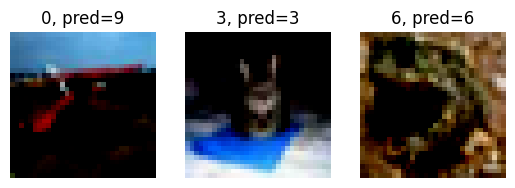

In [52]:
net = ResNet(num_class).to(device)
net.load_state_dict(torch.load("alex_cifar10_010.pth"))
net.eval()
vis_data = tv.datasets.CIFAR10("./cifar10_dataset", train=False, transform=transform)
vis_iter = torch.utils.data.DataLoader(vis_data, batch_size=1, shuffle=True)

_, ax = plt.subplots(1, 3)
for i, (x, y) in enumerate(vis_iter):
    if i >= 3:
        break
    x: Tensor = x.to(device)
    y: Tensor = y.to(device)
    pred: Tensor = net(x).argmax()
    x.squeeze_()
    y.squeeze_()
    pred.squeeze_()
    ax[i].set_title(f"{y.data}, pred={pred.data}")
    ax[i].imshow(x.cpu().permute(1, 2, 0).numpy())
    ax[i].axis('off')
plt.show()